### Importing the necessary libraries
Subsequently the databases is connected and assigned to the variable cnx

In [2]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
cnx = sqlite3.connect('database.sqlite')

### Assigning different tables to different Dataframes

In [3]:
country_df = pd.read_sql_query("SELECT * FROM Country", cnx)
league_df = pd.read_sql_query("SELECT * FROM League", cnx)
match_df = pd.read_sql_query("SELECT * FROM Match", cnx)
team_df = pd.read_sql_query("SELECT * FROM Team", cnx)
player_df = pd.read_sql_query("SELECT * FROM Player", cnx)
player_att_df = pd.read_sql_query("SELECT * FROM Player_Attributes", cnx)
team_att_df = pd.read_sql_query("SELECT * FROM Team_Attributes", cnx)
ss = pd.read_sql_query("SELECT * FROM sqlite_sequence", cnx)

# <font color='red'> PART 1 </font>
### Getting to know the match_df Dataframe (the largest Dataframe in here)
team_att_df and player_att_df are both large dataframes but are not as important as match df and will be explored later
* First we check the column titles available in the dataframe
+ Apparently there are basic info about the match (time, league, date, results) & players' name in the starting lineup and their coordinates, which can be a source to work out their playing position & match's timeline & various odds from a series of betting sites

In [3]:
len(match_df.columns)

115

In [4]:
for a in range (0,len(match_df.columns),5):
    print([i for i in match_df.columns[a:a+5]]) 

['id', 'country_id', 'league_id', 'season', 'stage']
['date', 'match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal']
['away_team_goal', 'home_player_X1', 'home_player_X2', 'home_player_X3', 'home_player_X4']
['home_player_X5', 'home_player_X6', 'home_player_X7', 'home_player_X8', 'home_player_X9']
['home_player_X10', 'home_player_X11', 'away_player_X1', 'away_player_X2', 'away_player_X3']
['away_player_X4', 'away_player_X5', 'away_player_X6', 'away_player_X7', 'away_player_X8']
['away_player_X9', 'away_player_X10', 'away_player_X11', 'home_player_Y1', 'home_player_Y2']
['home_player_Y3', 'home_player_Y4', 'home_player_Y5', 'home_player_Y6', 'home_player_Y7']
['home_player_Y8', 'home_player_Y9', 'home_player_Y10', 'home_player_Y11', 'away_player_Y1']
['away_player_Y2', 'away_player_Y3', 'away_player_Y4', 'away_player_Y5', 'away_player_Y6']
['away_player_Y7', 'away_player_Y8', 'away_player_Y9', 'away_player_Y10', 'away_player_Y11']
['home_player_1', 'home_player_2', 'h

### Before doing anything else let's first join the datasets
* Left joining match_df with team_df (for both away and home), league_df and country_df

In [5]:
#Checking the column names
print(league_df.columns)
print(country_df.columns)
print(team_df.columns)

Index(['id', 'country_id', 'name'], dtype='object')
Index(['id', 'name'], dtype='object')
Index(['id', 'team_api_id', 'team_fifa_api_id', 'team_long_name',
       'team_short_name'],
      dtype='object')


In [6]:
#Double-checking that all match_df's row entries are unique, and 
#countries are uniques, teams' names are unique, leagues' names are unique
print(match_df.match_api_id.nunique()-len(match_df))
print(country_df.name.nunique()-len(country_df))
print(league_df.name.nunique()-len(league_df))
print(team_df.team_long_name.nunique()-len(team_df))

0
0
0
-3


In [7]:
#Some checking reveals that luckily, none of the duplicated team name entries belong to the Premier League
team_df[team_df.team_long_name.duplicated(keep=False)]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
15,16,9996,111560.0,Royal Excel Mouscron,MOU
24,2510,274581,111560.0,Royal Excel Mouscron,MOP
182,31444,8031,111429.0,Polonia Bytom,POB
183,31445,8020,111429.0,Polonia Bytom,GOR
189,31451,8244,301.0,Widzew Łódź,LOD
199,32409,8024,301.0,Widzew Łódź,WID


### Merging the Dataframes (except for player_df, player_att_df & team_att_df)

In [4]:
league_info = pd.merge(left=league_df, right=country_df, how='inner',
                       left_on='country_id', right_on='id',suffixes=('_league','_country'))
league_info = league_info[['id_league','name_league','name_country']]
###########
match_almost_final = pd.merge(left=match_df, right=team_df[['team_api_id','team_long_name','team_short_name']], 
                              how='inner', left_on='home_team_api_id', right_on='team_api_id')
match_final = pd.merge(left=match_almost_final, right=team_df[['team_api_id','team_long_name','team_short_name']], 
                       how='inner', left_on='away_team_api_id', right_on='team_api_id',
                       suffixes=('_home', '_away'))
match_final.drop(labels=['team_api_id_home','team_api_id_away'], axis=1, inplace=True)
##########
combined_df = pd.merge(left=match_final, right=league_info, left_on='league_id', right_on='id_league',
                       how='inner')
combined_df.drop(labels=['country_id','id_league'], axis=1, inplace=True)
combined_df.head(5)

,id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,GBA,BSH,BSD,BSA,team_long_name_home,team_short_name_home,team_long_name_away,team_short_name_away,name_league,name_country
0,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,...,4.00,1.73,3.4,4.2,KRC Genk,GEN,Beerschot AC,BAC,Belgium Jupiler League,Belgium
1,483,1,2009/2010,5,2009-08-30 00:00:00,665353,9987,9993,1,1,...,3.75,1.83,3.3,3.8,KRC Genk,GEN,Beerschot AC,BAC,Belgium Jupiler League,Belgium
2,524,1,2010/2011,1,2010-08-01 00:00:00,838476,9987,9993,2,1,...,3.50,NaN,NaN,NaN,KRC Genk,GEN,Beerschot AC,BAC,Belgium Jupiler League,Belgium
3,759,1,2011/2012,1,2011-07-30 00:00:00,1032694,9987,9993,3,1,...,6.25,1.44,4.0,6.5,KRC Genk,GEN,Beerschot AC,BAC,Belgium Jupiler League,Belgium
4,1014,1,2012/2013,11,2012-10-20 00:00:00,1224064,9987,9993,3,0,...,5.50,1.53,3.8,5.5,KRC Genk,GEN,Beerschot AC,BAC,Belgium Jupiler League,Belgium


### Checking the null values inside the table

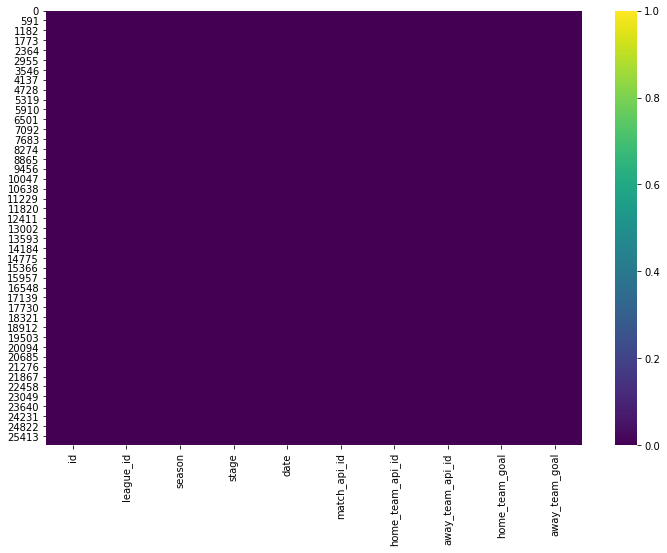

In [9]:
plt.figure(figsize=[12,8])
sns.heatmap(combined_df[['id', 'league_id', 'season', 'stage', 'date', 'match_api_id',
                         'home_team_api_id', 'away_team_api_id','home_team_goal','away_team_goal']].isnull(), 
                        cmap='viridis', vmin=0, vmax=1)

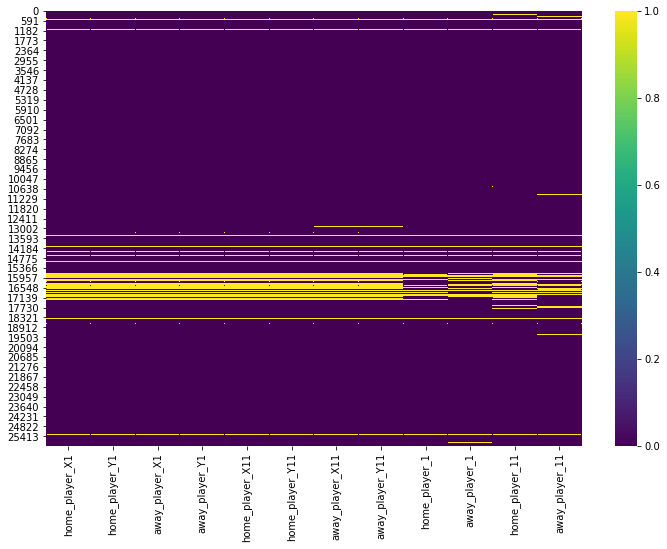

In [10]:
#There are many missing values inside the fields documenting players' positions and names, however
plt.figure(figsize=[12,8])
sns.heatmap(combined_df[['home_player_X1','home_player_Y1','away_player_X1','away_player_Y1',
                         'home_player_X11','home_player_Y11','away_player_X11','away_player_Y11',
                         'home_player_1','away_player_1','home_player_11','away_player_11']].isnull(), 
                        cmap='viridis', vmin=0, vmax=1)

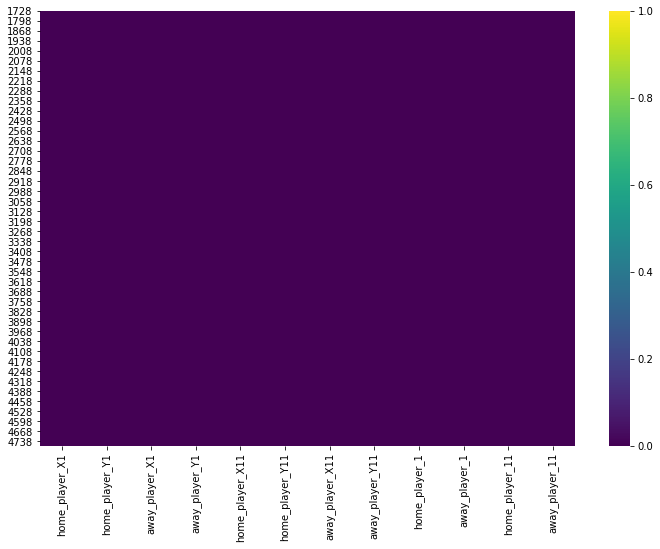

In [11]:
#Fortunately, there is no such missing values (in the fields related to players) inside the Premier League 
plt.figure(figsize=[12,8])
sns.heatmap(combined_df[combined_df.name_country=='England']
            [['home_player_X1','home_player_Y1','away_player_X1','away_player_Y1',
              'home_player_X11','home_player_Y11','away_player_X11','away_player_Y11',
              'home_player_1','away_player_1','home_player_11','away_player_11']].isnull(), 
            cmap='viridis', vmin=0, vmax=1)

### Manipulating the dataframe - computing the result column

In [12]:
#Computing the result column
def check_result(x, y):
    if x>y:
        return 'Home_wins'
    elif x<y:
        return 'Away_wins'
    else:
        return 'Draw'
combined_df['Results'] = list(map(check_result, combined_df.home_team_goal, combined_df.away_team_goal))

### Determining and create formation columns
Let's first try to plot the two teams' formation for an example of a few matches (maybe first 2)  
Of only those matched played in the Premier League (so we have no null data for formation)

<Figure size 864x576 with 0 Axes>

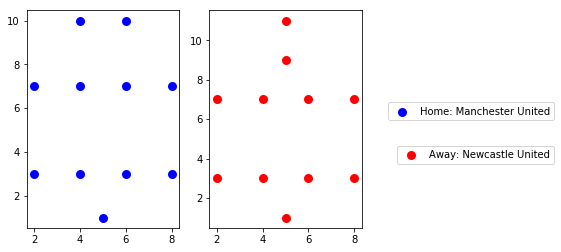

<Figure size 864x576 with 0 Axes>

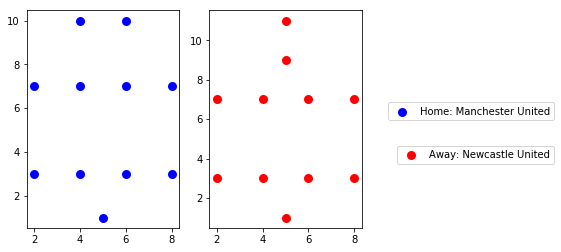

In [5]:
combined_df_copy = combined_df[combined_df.name_country=='England'].copy()
combined_df_copy['home_player_X1']=5
combined_df_copy['away_player_X1']=5

for j in range(2):
    plt.figure(figsize=[12,8])
    axes=plt.subplots(nrows=1, ncols=2)
    i=10
    axes[1][0].scatter(x=list(combined_df_copy.iloc[j].iloc[i:i+11]), y=list(combined_df_copy.iloc[j].iloc[i+22:i+33]), 
                   c='blue', lw=3)
    axes[1][0].legend(labels = ['Home: '+combined_df_copy.iloc[j]['team_long_name_home'],], bbox_to_anchor=[3.5,0.6])
    axes[1][1].scatter(x=list(combined_df_copy.iloc[j].iloc[i+11:i+22]), y=list(combined_df_copy.iloc[j].iloc[i+33:i+44]), 
                   c='red', lw=3)
    axes[1][1].legend(labels = ['Away: '+combined_df_copy.iloc[j]['team_long_name_away'],], bbox_to_anchor=[2.3,0.4])

Secondly we will create a column documenting the formation for both Home and Away team

In [14]:
from sortedcontainers import SortedSet 
home_formation_list = []
away_formation_list = []
for j in range(len(combined_df_copy)):
    home_player_y_list = list(combined_df_copy.iloc[j].iloc[i+23:i+33]) #Keeper position is skipped
    home_unique_y_list = SortedSet(home_player_y_list)
    away_player_y_list = list(combined_df_copy.iloc[j].iloc[i+34:i+44]) #Keeper position is skipped
    away_unique_y_list = SortedSet(away_player_y_list)
    home_formation = [str(home_player_y_list.count(item)) for item in home_unique_y_list]
    away_formation = [str(away_player_y_list.count(item)) for item in away_unique_y_list]
    home_formation_list.append('-'.join(home_formation))
    away_formation_list.append('-'.join(away_formation))
combined_df_copy['Home formation'] = home_formation_list
combined_df_copy['Away formation'] = away_formation_list

In [19]:
combined_df_copy.to_excel('Premier League Match Info.xls')

# <font color='red'> PART 2 </font>
### Merge "matching" team's attributes (in FIFA online) to home team for each match
* An appropriate match is defined as
  + The date of attributes' update is earlier than the match date
  + The update is the latest update (i.e the TIME DELTA between match date and date of update is shortest when compared among various updates)

In [275]:
import datetime as dt
m_df_home_only = pd.merge(left=combined_df_copy, right=team_att_df, 
                      left_on='home_team_api_id', right_on='team_api_id',
                      how='inner',suffixes=('_match', ''))
##Merging combined_df_copy and team_attributes Dataframe
#date from match will be named "date_match". Update date will be named just "date"

In [276]:
length1 = len(massive_df_home_only)
m_df_home_only['date_match']=list(map(dt.datetime.strptime, massive_df_home_only['date_match'],
                                            length1*['%Y-%m-%d %H:%M:%S']))
m_df_home_only['date']=list(map(dt.datetime.strptime, massive_df_home_only['date'], 
                                            length1*['%Y-%m-%d %H:%M:%S']))
#Coverting to datetime format

In [277]:
m_df_home_only['date_delta_home']=m_df_home_only['date_match']-m_df_home_only['date']
gb = m_df_home_only.groupby(by='home_team_api_id').agg({'date':np.min})
gb.rename(columns={'date':'first_update_home'}, inplace=True)
m_df_home_only=m_df_home_only.join(gb, on='home_team_api_id',lsuffix='',rsuffix='_right')
m_df_home_only['match_status_home']=np.where(m_df_home_only['date_match']>=m_df_home_only['first_update_home']
                                     ,'After 1st update', 'Before 1st update')

In [278]:
m_df_home_only = m_df_home_only[(m_df_home_only['date_delta_home']>=dt.timedelta(0))
                                |(m_df_home_only['match_status_home']=='Before 1st update')]
#Keeping only entries where date of team's attributes change is earlier than the match date
m_df_home_only['rank_home']=m_df_home_only.groupby(by='match_api_id')['date_delta_home'].rank(ascending=True)
m_df_home_only=m_df_home_only[((m_df_home_only['rank_home']==1) & (m_df_home_only['match_status_home']=='After 1st update'))
                                                            |
            ((m_df_home_only['date']==m_df_home_only['first_update_home'])&(m_df_home_only['match_status_home']=='Before 1st update'))]
# ranking of 1 <=> shortest time delta <=> earliest update. Groupby match_id

In [279]:
m_df_home_only.head(10)

,id_match,league_id,season,stage,date_match,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,date_delta_home,first_update_home,match_status_home,rank_home
0,1729,1729,2008/2009,1,2008-08-17,489042,10260,10261,1,1,...,Medium,50,Press,40,Normal,Cover,-554 days,2010-02-22,Before 1st update,6.0
6,2494,1729,2010/2011,1,2010-08-16,839802,10260,10261,3,0,...,Medium,50,Press,40,Normal,Cover,175 days,2010-02-22,After 1st update,1.0
13,2913,1729,2011/2012,13,2011-11-26,1024845,10260,10261,1,1,...,Medium,45,Press,65,Normal,Cover,277 days,2010-02-22,After 1st update,1.0
20,3353,1729,2012/2013,19,2012-12-26,1229300,10260,10261,4,3,...,Medium,50,Press,56,Normal,Cover,308 days,2010-02-22,After 1st update,1.0
27,3693,1729,2013/2014,15,2013-12-07,1474518,10260,10261,0,1,...,Medium,49,Press,56,Normal,Cover,78 days,2010-02-22,After 1st update,1.0
34,4105,1729,2014/2015,18,2014-12-26,1724158,10260,10261,3,1,...,Medium,41,Press,56,Normal,Cover,98 days,2010-02-22,After 1st update,1.0
40,4613,1729,2015/2016,3,2015-08-22,1988734,10260,10261,0,0,...,Medium,41,Press,56,Normal,Cover,337 days,2010-02-22,After 1st update,1.0
42,1739,1729,2008/2009,10,2008-10-29,489132,10260,8654,2,0,...,Medium,50,Press,40,Normal,Cover,-481 days,2010-02-22,Before 1st update,6.0
48,2312,1729,2009/2010,28,2010-02-23,659091,10260,8654,3,0,...,Medium,50,Press,40,Normal,Cover,1 days,2010-02-22,After 1st update,1.0
54,2709,1729,2010/2011,3,2010-08-28,839834,10260,8654,3,0,...,Medium,50,Press,40,Normal,Cover,187 days,2010-02-22,After 1st update,1.0


### Now we do the same for away team

In [286]:
m_df_home_n_away = pd.merge(left=m_df_home_only, right=team_att_df, 
                             left_on='away_team_api_id', right_on='team_api_id',
                             how='inner',suffixes=('_home_attribute', '_away_attribute'))

In [287]:
length2 = len(m_df_home_n_away)
m_df_home_n_away['date_away_attribute']=list(map(dt.datetime.strptime, m_df_home_n_away['date_away_attribute'], 
                                                length2*['%Y-%m-%d %H:%M:%S']))
#Coverting to datetime format

In [288]:
m_df_home_n_away['date_delta_away']=m_df_home_n_away['date_match']-m_df_home_n_away['date_away_attribute']
gb = m_df_home_n_away.groupby(by='away_team_api_id').agg({'date_away_attribute':np.min})
gb.rename(columns={'date_away_attribute':'first_update_away'}, inplace=True)
m_df_home_n_away=m_df_home_n_away.join(gb, on='away_team_api_id',lsuffix='',rsuffix='_right')
m_df_home_n_away['match_status_away']=np.where(m_df_home_n_away['date_match']>=m_df_home_n_away['first_update_away']
                                     ,'After 1st update', 'Before 1st update')

In [289]:
m_df_home_n_away = m_df_home_n_away[(m_df_home_n_away['date_delta_away']>=dt.timedelta(0))
                                   |(m_df_home_n_away['match_status_away']=='Before 1st update')]
#Keeping only entries where date of team's attributes change is earlier than the match date
m_df_home_n_away['rank_away']=m_df_home_n_away.groupby(by='match_api_id')['date_delta_away'].rank(ascending=True)
m_df_home_n_away=m_df_home_n_away[((m_df_home_n_away['rank_away']==1) & (m_df_home_n_away['match_status_away']=='After 1st update'))
                                                            |
            ((m_df_home_n_away['date_away_attribute']==m_df_home_n_away['first_update_away'])&(m_df_home_n_away['match_status_away']=='Before 1st update'))]
# ranking of 1 <=> shortest time delta <=> earliest update. Groupby match_id

In [320]:
m_df_home_n_away.head(10)

,id_match,league_id,season,stage,date_match,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,...,defencePressureClass_away_attribute,defenceAggression_away_attribute,defenceAggressionClass_away_attribute,defenceTeamWidth_away_attribute,defenceTeamWidthClass_away_attribute,defenceDefenderLineClass_away_attribute,date_delta_away,first_update_away,match_status_away,rank_away
0,1729,1729,2008/2009,1,2008-08-17,489042,10260,10261,1,1,...,Medium,65,Press,45,Normal,Cover,-554 days,2010-02-22,Before 1st update,6.0
6,2494,1729,2010/2011,1,2010-08-16,839802,10260,10261,3,0,...,Medium,65,Press,45,Normal,Cover,175 days,2010-02-22,After 1st update,1.0
13,2913,1729,2011/2012,13,2011-11-26,1024845,10260,10261,1,1,...,Medium,45,Press,50,Normal,Cover,277 days,2010-02-22,After 1st update,1.0
20,3353,1729,2012/2013,19,2012-12-26,1229300,10260,10261,4,3,...,Medium,48,Press,42,Normal,Cover,308 days,2010-02-22,After 1st update,1.0
27,3693,1729,2013/2014,15,2013-12-07,1474518,10260,10261,0,1,...,Medium,39,Press,51,Normal,Cover,78 days,2010-02-22,After 1st update,1.0
34,4105,1729,2014/2015,18,2014-12-26,1724158,10260,10261,3,1,...,Medium,54,Press,51,Normal,Cover,98 days,2010-02-22,After 1st update,1.0
40,4613,1729,2015/2016,3,2015-08-22,1988734,10260,10261,0,0,...,Medium,54,Press,51,Normal,Cover,337 days,2010-02-22,After 1st update,1.0
42,1950,1729,2008/2009,3,2008-08-30,489063,9825,10261,3,0,...,Medium,65,Press,45,Normal,Cover,-541 days,2010-02-22,Before 1st update,6.0
48,2510,1729,2010/2011,11,2010-11-07,839915,9825,10261,0,1,...,Medium,65,Press,45,Normal,Cover,258 days,2010-02-22,After 1st update,1.0
56,3069,1729,2011/2012,28,2012-03-12,1025678,9825,10261,2,1,...,Medium,48,Press,42,Normal,Cover,19 days,2010-02-22,After 1st update,1.0


In [321]:
m_df_home_n_away.to_excel('Premier League Match Info With Team Attributes.xls')